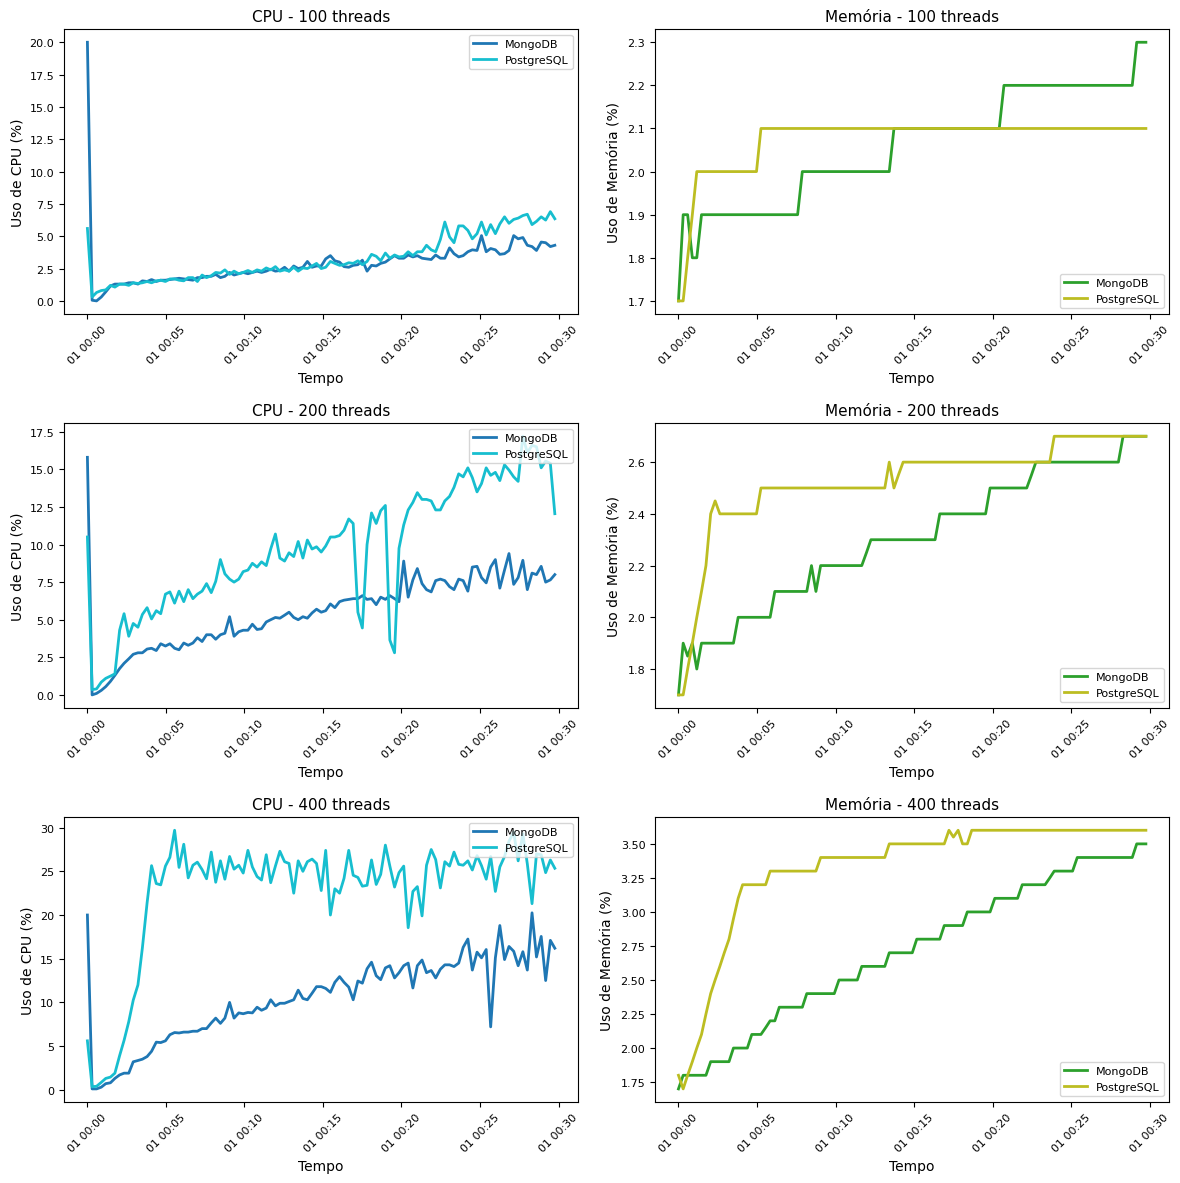

✅ Imagem salva em plots/resource_usage_comparativo_mixed.png


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# === ALTERE AQUI PARA O CENÁRIO DESEJADO ===
cenario_base = "mixed"  # Opções: 'insert', 'read', 'update', 'mixed'
threads_list = [100, 200, 400]

# === Paleta de cores ===
cores_cpu = {'MongoDB': 'tab:blue', 'PostgreSQL': 'tab:cyan'}
cores_mem = {'MongoDB': 'tab:green', 'PostgreSQL': 'tab:olive'}

# === Criar figura com 3 linhas x 2 colunas ===
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))  # Expansão dos gráficos

for idx, threads in enumerate(threads_list):
    scenario = f"1800_seconds_{threads}_threads_{cenario_base}_workload"
    mongo_file = f'resource-usage/mongo_{scenario}.csv'
    pg_file = f'resource-usage/pg_{scenario}.csv'

    if not os.path.exists(mongo_file) or not os.path.exists(pg_file):
        print(f"Arquivo não encontrado: {mongo_file} ou {pg_file}")
        continue

    df_mongo = pd.read_csv(mongo_file)
    df_pg = pd.read_csv(pg_file)

    df_mongo['Time'] = pd.to_datetime(df_mongo['Time'], unit='s')
    df_pg['Time'] = pd.to_datetime(df_pg['Time'], unit='s')
    df_mongo['ElapsedTime'] = (df_mongo['Time'] - df_mongo['Time'].iloc[0]).dt.total_seconds()
    df_pg['ElapsedTime'] = (df_pg['Time'] - df_pg['Time'].iloc[0]).dt.total_seconds()

    common_time = pd.Series(sorted(set(df_mongo['ElapsedTime']).union(df_pg['ElapsedTime'])))
    df_mongo_interp = df_mongo.set_index('ElapsedTime').reindex(common_time).interpolate(method='linear')
    df_pg_interp = df_pg.set_index('ElapsedTime').reindex(common_time).interpolate(method='linear')
    time_index = pd.to_datetime(common_time, unit='s')

    # Reduzir pontos para melhor visualização
    N = 35
    time_index = time_index[::N]
    df_mongo_interp = df_mongo_interp.iloc[::N]
    df_pg_interp = df_pg_interp.iloc[::N]

    row = idx

    # CPU Usage
    axs[row, 0].plot(time_index, df_mongo_interp['CPU Usage'], label='MongoDB', color=cores_cpu['MongoDB'], linewidth=2)
    axs[row, 0].plot(time_index, df_pg_interp['CPU Usage'], label='PostgreSQL', color=cores_cpu['PostgreSQL'], linewidth=2)
    axs[row, 0].set_title(f'CPU - {threads} threads', fontsize=11)
    axs[row, 0].set_xlabel('Tempo', fontsize=10)
    axs[row, 0].set_ylabel('Uso de CPU (%)', fontsize=10)
    axs[row, 0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[row, 0].tick_params(axis='y', labelsize=8)
    axs[row, 0].legend(fontsize=8, loc='upper right')

    # Memory Usage
    axs[row, 1].plot(time_index, df_mongo_interp['Memory Usage'], label='MongoDB', color=cores_mem['MongoDB'], linewidth=2)
    axs[row, 1].plot(time_index, df_pg_interp['Memory Usage'], label='PostgreSQL', color=cores_mem['PostgreSQL'], linewidth=2)
    axs[row, 1].set_title(f'Memória - {threads} threads', fontsize=11)
    axs[row, 1].set_xlabel('Tempo', fontsize=10)
    axs[row, 1].set_ylabel('Uso de Memória (%)', fontsize=10)
    axs[row, 1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[row, 1].tick_params(axis='y', labelsize=8)
    axs[row, 1].legend(fontsize=8, loc='lower right')

plt.tight_layout()
output_path = f'plots/resource_usage_comparativo_{cenario_base}.png'
os.makedirs('plots', exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Imagem salva em {output_path}")
